Ce notebook a pour but de préparer les données issues du site datagov afin qu'on puisse les modéliser.

La période est : 2005-2016 ( sauf 2009)

on a quatre table : caracteristiques, usagers, lieux et vehicules.

Dans ce notebook, nous n'allons pas imputer les valeurs manquantes dans le but de laisser l'imputation à l'algorithme xgboost afin de comparer les performance avec ou sans imputation 
.

### Required libraries :

In [206]:
import pandas as pd  # dataframe structure
import numpy as np  # array structure
import seaborn as sns # visualization
import matplotlib.pyplot as plt # plot
import glob, os  # dealing with OS and Files, reading files etc 

### Loading data :

<mark>A noter j'ai supprimé les données concernant 2009 car n'a pas la même forme que les autres ( juste pour lire tout en même temps)</mark>

In [2]:
#lieux2009=pd.read_csv('lieux_2009.csv',encoding='latin-1') : ok
#usagers2009=pd.read_csv('usagers_2009.csv',encoding='latin-1') : ok
#veh2009=pd.read_csv('vehicules_2009.csv',encoding='latin-1') : ok
#cara2009=pd.read_csv('caracteristiques_2009.csv') : cette table est mal saisie toutes les valeurs sont concaténées
# on laisse les données pour 2009

Dans un premier temps on va lire tous les fichiers csv qu'on a téléchargé à partir du site datagov :

####  Data set about caracteristiques :

In [225]:
path =r'dataset/caracteristiques' # path containing all csv files about caracteristiques (  use your own path)
allFiles = glob.glob(path + "/*.csv")  # a list containing files names (all csv files)
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1') # read csv file (file_)
    list_.append(df)  # append the the dataframe df to the lust list_
caracteristiques = pd.concat(list_)  # concat all dataframes existing in list_

#####  Data set about usagers :

In [4]:
path =r'dataset/usagers' 
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
usagers = pd.concat(list_)

####  Data set about lieux :

In [74]:
path =r'dataset/lieux' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
lieux = pd.concat(list_)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Data set about vehicules :

In [6]:
path =r'dataset/vehicules' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
vehicules = pd.concat(list_)

##### Short description about our dataframes :

In [7]:
print("==== Shape of our dataframes ====")
print("The shape of caracteristiques is :", caracteristiques.shape)
print("The shape of lieux is :", lieux.shape)
print("The shape of vehicules is :", vehicules.shape)
print("The shape of usagers is :", usagers.shape)
print("==== Count Missing Data (note that 0 means also a nan value but should be converted to nan later during cleaning stage)  ====")
print("Total missing data in  caracteristiques is :", caracteristiques.isnull().sum().sum())
print("Total missing data in  lieux is :", lieux.isnull().sum().sum())
print("Total missing data in  vehicules is :", vehicules.isnull().sum().sum())
print("Total missing data in  usagers is :", usagers.isnull().sum().sum())

==== Shape of our dataframes ====
The shape of caracteristiques is : (765576, 16)
The shape of lieux is : (765576, 18)
The shape of vehicules is : (1307042, 9)
The shape of usagers is : (1710043, 12)
==== Count Missing Data (note that 0 means also a nan value but should be converted to nan later during cleaning stage)  ====
Total missing data in  caracteristiques is : 1433891
Total missing data in  lieux is : 2045729
Total missing data in  vehicules is : 1455
Total missing data in  usagers is : 131184


### Tâche 1 : Prédiction de la gravité des accidents

Dans cette partie nous allons essayer d'effectuer un apprentissage supervisé sur la variable : gravité de l'accident

Nous ne prenons pas en compte les variables spatiales. Donc nous ne faisons pas de nettoyage pour ces variables pour cette première tâche, mais nous allons nettoyer les autres variables ( imputation des valeurs manquantes, les points abberrants)

On va nettoyer les quatre tables qu'on vient de récupérer ci-dessus. Chaque table contient l'historique de 2005 jusqu'à 2016 ( sauf 2009).
Une fois les tables sont bien nettoyées, on va effectuer une jointure afin d'avoir toutes les variables nécessaires pour effectuer notre classification. La table résultante sera à la fois notre jeu de données sur toute la période(2005-2016) et  contenant les sous jeu de données correspondants à chaque année.
Avant de commencer la modélisation, nous allons effectuer des explorations ainsi que des analyses statistiques visant d'une part à visualiser les données et d'autre part à comprendre le jeu de donnée. Cette étape est primordiale car il constitue une étape de la méthode CRISP -largement utilisée dans le monde industrielle- utilisée en data mining.

### Data cleaning  :

---
####  La table caracteristiques 
---

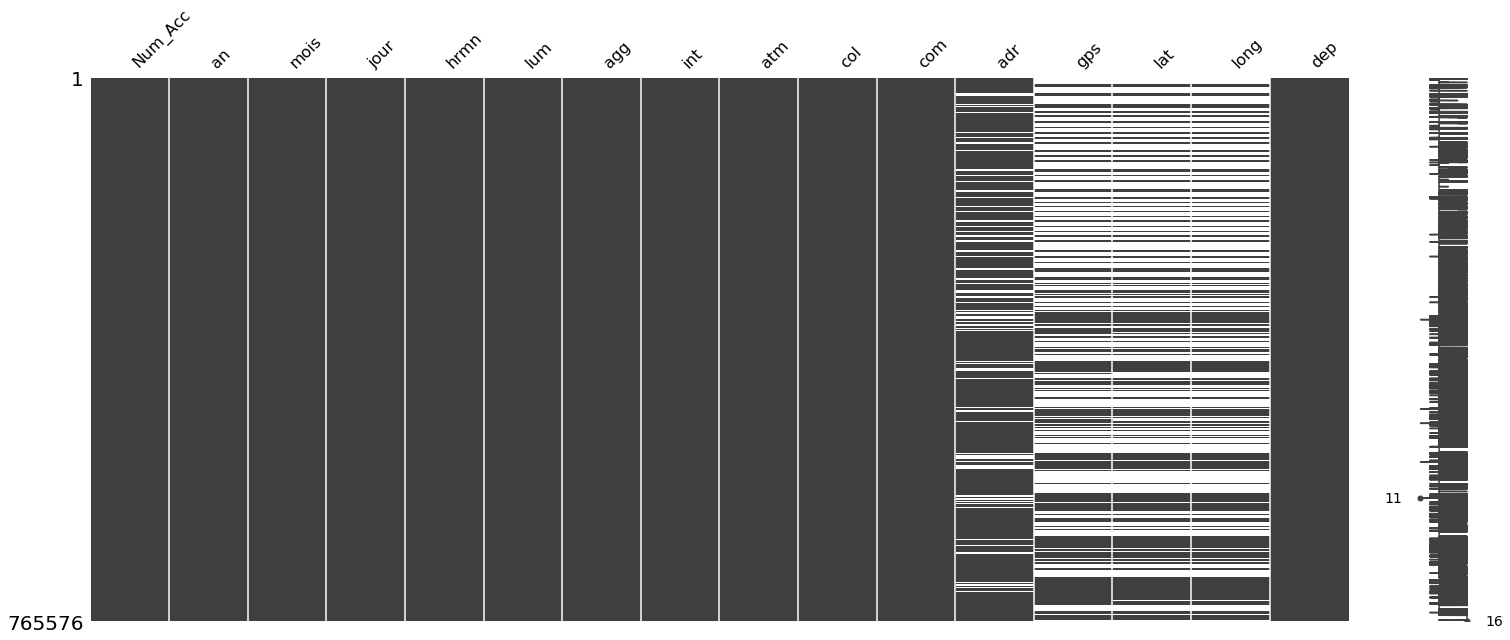

In [8]:
import missingno as msno
# ici on prend en compte que les nan
msno.matrix(caracteristiques)

###### gps :

In [9]:
print(len(caracteristiques.gps.unique()))
caracteristiques.gps.unique()
#On voit que gps a 8 valeurs uniques, alors que dans le documents pdf il n'y a que 5 ( M,A,G,R et Y)

9


array(['M', nan, '0', 'A', 'G', 'R', 'S', 'T', 'Y'], dtype=object)

nan, 0 et S se sont considérées comme des valeurs manquantes

In [10]:
caracteristiques[caracteristiques.gps=='S'].shape

(3, 16)

In [11]:
caracteristiques[caracteristiques.gps=='0'].shape

(9, 16)

In [12]:
caracteristiques.gps.isnull().sum()

432956

In [13]:
# puisque cette variable est utilisée pour localiser l'accident, on va remplacer '0' et'S' par nan.
caracteristiques.loc[:,['gps']]=caracteristiques.loc[:,['gps']].replace('0',np.nan)
caracteristiques.loc[:,['gps']]=caracteristiques.loc[:,['gps']].replace('S',np.nan)

In [14]:
#verification :
print(len(caracteristiques.gps.unique()))
caracteristiques.gps.unique()

7


array(['M', nan, 'A', 'G', 'R', 'T', 'Y'], dtype=object)

On peut remarquer que il y a des nan dans la france metropole et la france d'outre mer.

-Donc pour France Metropole on remplace gps par M ( il suffit de voir dep<950)

-Donc pour la france d'outre mer il suffit de voir aussi dep.

In [18]:
# France M :
caracteristiques.ix[caracteristiques.dep<=950,'gps']=caracteristiques.ix[caracteristiques.dep<=950,'gps'].replace('nan','M')

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [19]:
caracteristiques.ix[caracteristiques.dep==971,'gps']=caracteristiques.ix[caracteristiques.dep==971,'gps'].replace('nan','A')
caracteristiques.ix[caracteristiques.dep==972,'gps']=caracteristiques.ix[caracteristiques.dep==972,'gps'].replace('nan','A')
caracteristiques.ix[caracteristiques.dep==973,'gps']=caracteristiques.ix[caracteristiques.dep==973,'gps'].replace('nan','G')
caracteristiques.ix[caracteristiques.dep==974,'gps']=caracteristiques.ix[caracteristiques.dep==974,'gps'].replace('nan','R')
caracteristiques.ix[caracteristiques.dep==976,'gps']=caracteristiques.ix[caracteristiques.dep==976,'gps'].replace('nan','Y')

Donc cette variable est bien imputée.
Il reste juste le fait de fixer le type de cette variable. Elle est déjà 'object'.

###### jour :

In [20]:
print(len(caracteristiques.jour.unique()))
caracteristiques.jour.unique()
# pas de soucis pour cette variable

31


array([12, 21,  4, 10, 28,  3, 18, 25, 29, 23, 11,  1, 30, 19,  9, 31, 15,
       13, 26,  2,  6,  8, 20, 16,  7,  5, 24, 14, 17, 22, 27], dtype=int64)

###### mois :

In [21]:
print(len(caracteristiques.mois.unique()))
caracteristiques.mois.unique()
# pas de soucis pour cette variable


12


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

##### an :

In [22]:
print(len(caracteristiques.an.unique()))
caracteristiques.an.unique()
#pareil

11


array([ 5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16], dtype=int64)

###### hrmn: 

In [226]:
caracteristiques.hrmn.min(), caracteristiques.hrmn.max()
# donc ici il s'agit de l'heure et les minutes
# exemple : 2359 ==> 23:59
# on cherche le len des éléments 
mes_len=[len(ele) for ele in set(list(caracteristiques.hrmn.astype(str).values))]
[ele for ele in set(mes_len)]
# Il y a donc différents len ( de 1 ==>4) 
# donc if faut du traitement
# si len == 4 ==> ajouter : entre les deux chiffres
# si len == 3 ==> ajouter 0 en avant puis : entre les deux chiffres
# si len == 2 ==> ajouter deux 00 vers la fin puis : 
# si len == 1 ==> ajouter 0 avant et 00 à la fin puis : 

[1, 2, 3, 4]

In [227]:
# change type to str for easy handling :
caracteristiques.hrmn=caracteristiques.hrmn.astype(str)

In [231]:
# len ==4 : split with len=2 then add :
caracteristiques.ix[caracteristiques.hrmn.str.len()==4,'hrmn']= caracteristiques.ix[caracteristiques.hrmn.str.len()==4,'hrmn'].str.extract('(.{2,2})' * 2).apply(lambda x: ':'.join(x), axis=1)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [232]:
# len == 3 :  add 0 to into the start then split then add :
caracteristiques.ix[caracteristiques.hrmn.str.len()==3,'hrmn']=('0'+caracteristiques.ix[caracteristiques.hrmn.str.len()==3,'hrmn']).str.extract('(.{2,2})' * 2).apply(lambda x: ':'.join(x), axis=1)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [233]:
#len =2 : add 00 to thestart then split then add : 
caracteristiques.ix[caracteristiques.hrmn.str.len()==2,'hrmn']=('00'+caracteristiques.ix[caracteristiques.hrmn.str.len()==2,'hrmn'] ).str.extract('(.{2,2})' * 2).apply(lambda x: ':'.join(x), axis=1)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [235]:
# len == 1 ==> ajouter 0 avant et 00 à la fin puis : 
caracteristiques.ix[caracteristiques.hrmn.str.len()==1,'hrmn']=('0'+caracteristiques.ix[caracteristiques.hrmn.str.len()==1,'hrmn'] +'00').str.extract('(.{2,2})' * 2).apply(lambda x: ':'.join(x), axis=1)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [236]:
# verification :
mes_len_apres=[len(ele) for ele in set(list(caracteristiques.hrmn.astype(str).values))]
[ele for ele in set(mes_len_apres)]
# c'est bon ( len==5 car on a ajouté les :)

[5]

###### lum :

In [237]:
print(len(caracteristiques.lum.unique()))
caracteristiques.lum.unique()
# bon

5


array([3, 1, 5, 4, 2], dtype=int64)

###### agg


In [238]:
print(len(caracteristiques['agg'].unique()))
caracteristiques['agg'].unique()
#bon

2


array([2, 1], dtype=int64)

###### intersection :

In [239]:
print(len(caracteristiques.int.unique()))
caracteristiques.int.unique()

10


array([1, 2, 9, 0, 6, 8, 3, 4, 7, 5], dtype=int64)

###### atm :

In [240]:
print(len(caracteristiques.atm.unique()))
caracteristiques.atm.unique()
# 

10


array([  1.,   2.,   3.,   8.,   9.,   7.,   6.,   4.,   5.,  nan])

###### collision :

In [241]:
print(len(caracteristiques.col.unique()))
caracteristiques.col.unique()
# nan values are in 

8


array([  3.,   1.,   5.,   6.,   2.,   4.,   7.,  nan])

###### Adresse postale :

In [242]:
print(len(caracteristiques.adr.unique()))
caracteristiques.adr.unique()
# des adresse, donc pas de problémes ( sauf erreur de saisie. on va lire adresse par adresse bien sûr pour s'assurer )

337657


array(['CD41B', 'rue de Lille', nan, ..., 'tsoundzou-KOUALE ( rue d',
       "passamanty-M'hogoni (rue", 'kaweni-GEOLE (la)'], dtype=object)

##### Variables numériques :

###### lon/lat

 lat et lon sont des variables numériques. Ils présentent plus de 50% de valeurs manquantes. On les garde comme ça pour l'instant.

###### com :

Chaque dépertement contient des communes. Dans notre base les déparetements sont chiffrés entre 10 et 976. 

RQ :
    - on peut aggréger nos données par département et étudier chaque département tout seul
    - On peut encore ajouter de la granulité et aggréger par commune.


###### dep

In [243]:
#pas de valeur manquante pour cette variables
print("il y a ",len(caracteristiques.dep.unique()),"départements ")
print(sorted(list(caracteristiques.dep.unique())))


il y a  101 départements 
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 201, 202, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 971, 972, 973, 974, 976]


In [244]:
dep_values=list(caracteristiques.dep.astype(str).values)

In [245]:
set([dep for dep in dep_values if len(dep)==2])
# on a bien toutes les valeurs correspondantes au dépertement de numéro entre 1 et 9.

{'10', '20', '30', '40', '50', '60', '70', '80', '90'}

In [246]:
print(set([dep for dep in dep_values if len(dep)==3 and dep[-1]!='0' and dep!='202' and dep!='201'])) 

{'973', '971', '972', '976', '974'}


In [247]:
# 201 et 202 remplacent 2A et 2B ( voir lien www.francegene.com/rech-fr/dep-fr.php) : donc pour ces deux valeurs pas de soucis
# mais les autres ils ne se terminent pas par 0 ?
#  normalement il y a 95 departement  d'après le lien ci-dessous, donc 950 doit être la plus grande valeur.
# A voir : soit se sont des nouveau dépertement ? sinon on va les remplacer par la plus courante valeurs.
# en fait les autres numéros sont celles de la france d'outre mer. plus précisement :
# 971 : num départemental de Guadeloupe
# 972 : Maritinique
# 973 : La Guyane 
# 974 : La Réunion
# 976 : Mayotte
# Donc c'est à nous de choisir : est ce que juste la france europééne ou aussi la france d'outre mer.

In [248]:
#save table to csv file :
caracteristiques.to_csv('data-without-imputing-all-years/caracteristiques_2005-2016.csv',index=False)

---
#### la table lieux : 
---

Commençons par un graphiques montrant la distribution des valeurs manquantes dans cette table.

In [44]:
#!pip install missingno # if you do not have this package try installing it using the given command

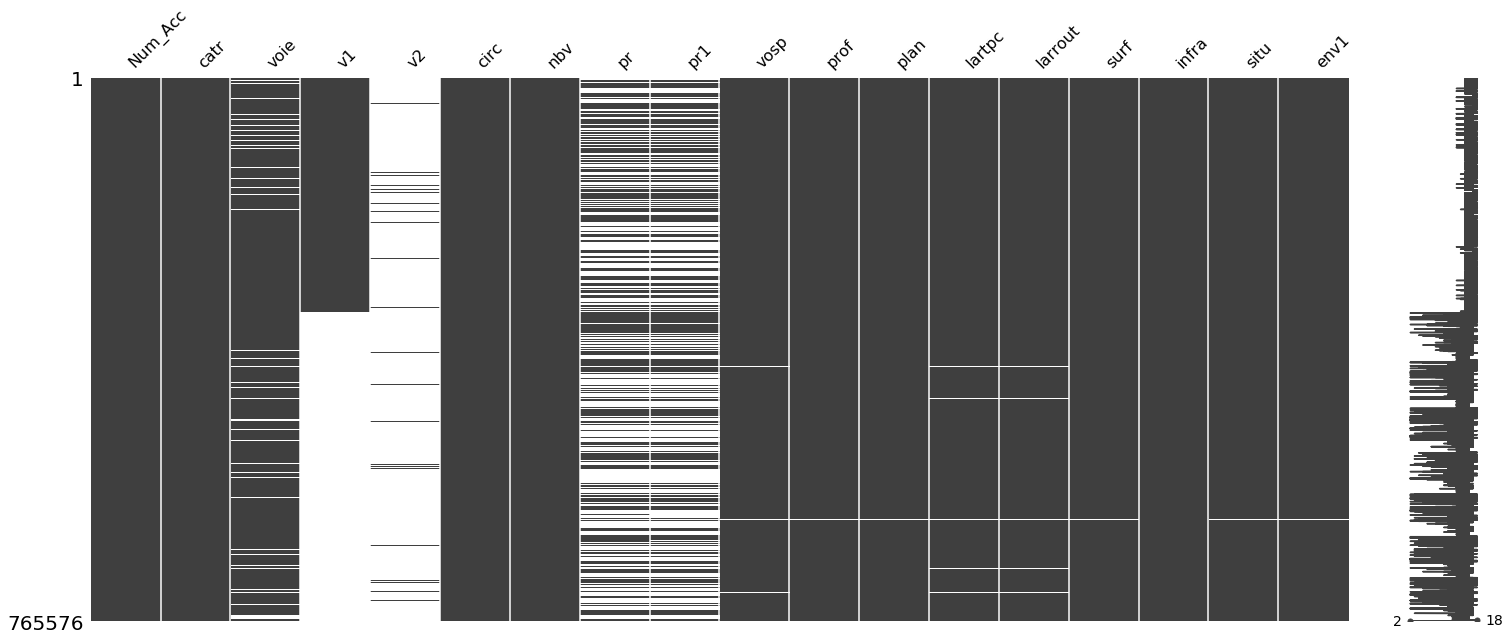

In [45]:
import missingno as msno
msno.matrix(lieux)

Comme vous voyez il y a des variables qui ont beaucoup de valeurs manquantes( ceci sans compter les valeurs '0'), surtout : v1,v2, pr et pr1.

###### catégorie de route :

In [75]:
print("Les valeurs uniques existantes dans la variable catr sont : \n",lieux.catr.unique())
# il y a nan dans cette série, donc nous devons les imputer

Les valeurs uniques existantes dans la variable catr sont : 
 [  3.   2.   4.   6.   9.   5.   1.  nan]


###### régime circulation :

In [76]:
print("Les valeurs uniques existantes dans la variable circ sont : ",lieux.circ.unique())

Les valeurs uniques existantes dans la variable circ sont :  [  2.   0.   3.   4.   1.  nan]


In [77]:
lieux.loc[:,['circ']]=lieux.loc[:,['circ']].replace(0,np.nan)

###### voie réservée :

In [78]:
print("Il y a {} comme valeurs uniques dans  la variable vosp".format(lieux.vosp.unique()))


Il y a [  0.   1.   3.   2.  nan] comme valeurs uniques dans  la variable vosp


In [79]:
print("taille 0 :",lieux[lieux.vosp==0].shape)
print("taille nan :",lieux.vosp.isnull().sum())
# on remarque que quasiment toute la colonne est en '0'.
# on garde 0 ( car la variable 0 ici a pour signification : pas de voie réservèe)
 

taille 0 : (717337, 18)
taille nan : 1382


###### profil de la route : 

In [80]:
print("Les valeurs uniques pour la varible prof sont : ",lieux.prof.unique())

Les valeurs uniques pour la varible prof sont :  [  1.   0.   2.   3.   4.  nan]


In [81]:
print("taille 0 :",lieux[lieux.prof==0].shape)
print("taille nan :",lieux.prof.isnull().sum())

taille 0 : (58716, 18)
taille nan : 982


In [82]:
lieux.loc[:,['prof']]=lieux.loc[:,['prof']].replace(0,np.nan)

###### Tracé en plan :
    
    

In [83]:
print("les valeurs uniques de la variable plan sont :",lieux.plan.unique())

les valeurs uniques de la variable plan sont : [  1.   3.   2.   0.   4.  nan]


In [84]:
print("taille 0 :",lieux[lieux.plan==0].shape)
print("taille nan :",lieux.plan.isnull().sum())

taille 0 : (52708, 18)
taille nan : 1001


In [85]:
lieux.loc[:,['plan']]=lieux.loc[:,['plan']].replace(0,np.nan)

###### Etat de la surface 

In [86]:
print("Les valeurs uniques pour la variable surf sont : ",lieux.surf.unique())

Les valeurs uniques pour la variable surf sont :  [  1.   2.   0.   9.   7.   8.   5.   6.   3.   4.  nan]


In [87]:
print("taille 0 :",lieux[lieux.surf==0].shape)
print("taille nan :",lieux.surf.isnull().sum())

taille 0 : (24885, 18)
taille nan : 949


In [88]:
lieux.loc[:,['surf']]=lieux.loc[:,['surf']].replace(0,np.nan)

###### situation de l'acccident

In [89]:
print("les valeurs uniques pour la variable situ sont :", lieux.situ.unique())

les valeurs uniques pour la variable situ sont : [  1.   5.   3.   4.   0.   2.  nan]


In [90]:
print("taille 0 :",lieux[lieux.situ==0].shape)
print("taille nan :",lieux.situ.isnull().sum())

taille 0 : (39296, 18)
taille nan : 943


In [91]:
lieux.loc[:,['situ']]=lieux.loc[:,['situ']].replace(0,np.nan)

###### point école :

In [92]:
# on sait pas pour cette variables quelles sont les veleurs prises
print("les valeurs uniques pour la variable env1 sont :",lieux.env1.unique())


les valeurs uniques pour la variable env1 sont : [  0.   3.  99.  nan]


###### voie :

In [93]:
print("les valeurs uniques pour la variable voie sont :", lieux.voie.unique())

les valeurs uniques pour la variable voie sont : [41.0 916.0 110.0 ..., 'D2204' '885' 2913.0]


In [94]:
print("total des nan dans voie :",lieux.voie.isnull().sum())

total des nan dans voie : 55754


In [95]:
lieux.loc[:,['voie']]=lieux.loc[:,['voie']].replace(0,np.nan)


###### Indice numériques du numéro de la route : 

In [96]:
print("Les valeurs uniques pour la variable v1 sont :",lieux.v1.unique())

Les valeurs uniques pour la variable v1 sont : [  0.   2.   1.   9.   6.   4.   5.   7.   3.   8.  nan]


In [97]:
lieux.loc[:,['v1']]=lieux.loc[:,['v1']].replace(0,np.nan)

###### Lettre V2

In [98]:
print("Les valeurs uniques pour la variable v2 sont :", lieux.v2.unique())
# il y a un probléme de encoding : /x04
# il y des nan 
# il y des 0  
# il faut comprendre la variable pour l'imputer.
# C'est juste un indice, on peut éliminer cette variable et garder que voie et v1

Les valeurs uniques pour la variable v2 sont : ['B' nan 'A' 'E' 'N' 'D' 'C' 'F' 'R' 'G' 'J' 'b' 'a' 'S' 'W' 'H' 'P' '\x04'
 'K' 'T' 'L' 'M' 'Z' 'O' 'I' 's' 'n' 'Q' 'e' 'V' 'd' 'c' 'z' 'U' 'v' 'm'
 'Y' 'w' 'y' 't' '0' '4' '1' '8' '2' '5' '6' '9' '3' '7' 'f' 'p' 'g' 'l'
 'r' 'X']


In [99]:
lieux=lieux.drop('v2',axis=1) # delete v2 from dataframe

###### nombre total de voie de circulation  :

In [100]:
print(sorted(set(list(lieux.nbv.unique()))))
# il y a des nan 

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, nan, 33.0, 36.0, 39.0, 40.0, 41.0, 42.0, 44.0, 45.0, 50.0, 52.0, 53.0, 54.0, 60.0, 62.0, 65.0, 70.0, 76.0, 84.0, 86.0, 90.0, 91.0, 99.0]


Pour les variables suivantes, elle sont à laisser car numériques( nan à traiter par xgboost)

###### Numéro PR :
    

###### Distance en mètres au PR :

###### Largeur du terre plein central TPC ( s il exist )

###### larrout

###### infra

On vient de finir le nettoyage de cette table. Il reste à donner le bon type pour chaque variable.

In [101]:
# save table to csv file
lieux.to_csv('data-without-imputing-all-years/lieux_2005-2016.csv',index=False)

---
#### la table usagers 
---

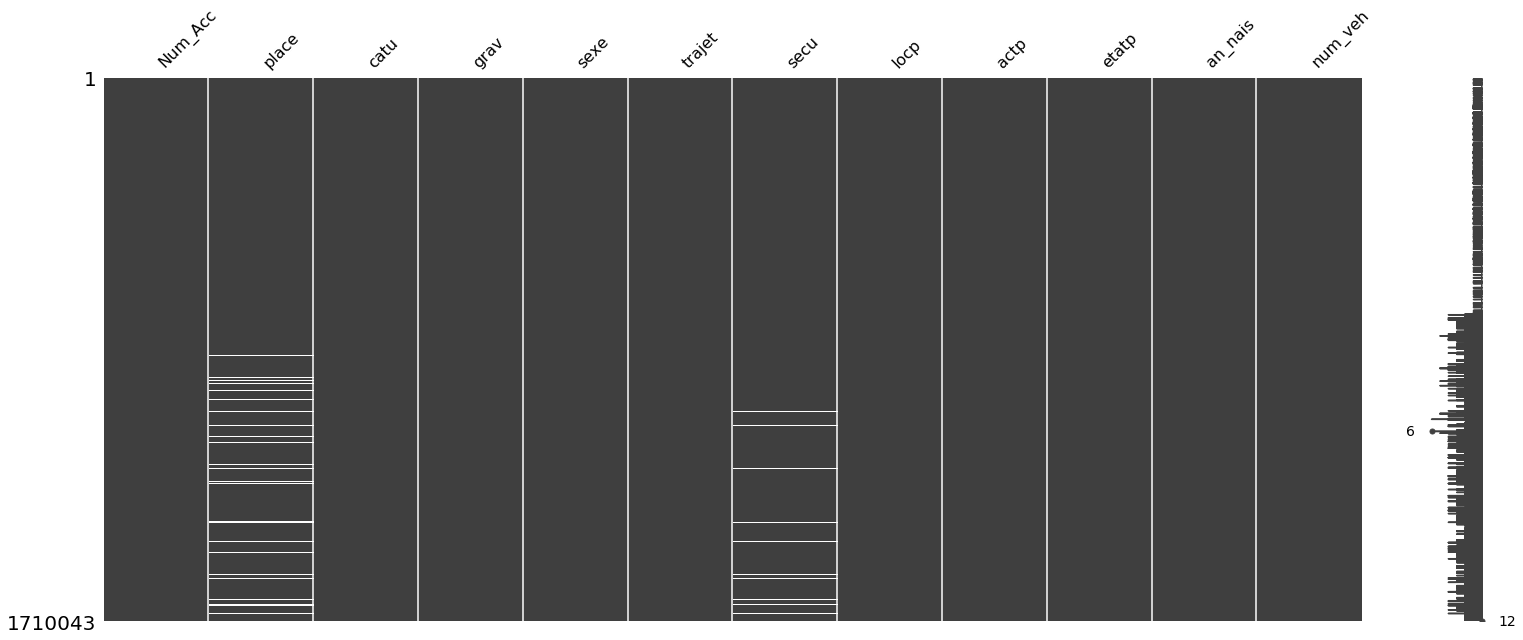

In [102]:
import missingno as msno
msno.matrix(usagers)

###### place : 

In [103]:
usagers.place.unique()

array([  1.,   2.,   4.,   5.,   3.,   0.,   8.,   9.,   7.,   6.,  nan])

In [104]:
print("taille 0 :" , usagers[usagers.place==0].shape)
print("taille nan :" , usagers.place.isnull().sum())


taille 0 : (60766, 12)
taille nan : 86734


In [105]:
usagers.loc[:,['place']]=usagers.loc[:,['place']].replace(0,np.nan)

###### Catégorie d'usager :

In [106]:
usagers.catu.unique()
#c'est bon

array([1, 2, 3, 4], dtype=int64)

###### Gravité de l'accident​ :

In [107]:
usagers.grav.unique()
#c'est bon

array([4, 3, 1, 2], dtype=int64)

###### Sexe de l'usager :


In [108]:
usagers.sexe.unique()
#c'est bon

array([1, 2], dtype=int64)

###### Annee de naissance de l'usager'

In [109]:
usagers.an_nais.dtype
# pas de soucis ici sauf si il y une erreur dans la saisie  d'une data :
print('min des dates :',usagers.an_nais.min())
print('max des dates :',usagers.an_nais.max())

min des dates : 1896.0
max des dates : 2016.0


In [110]:
# nan values :
usagers.an_nais.isnull().sum()

2337

###### Motif du déplacement au moment de l’accident :

In [111]:
usagers.trajet.unique()

array([  1.,   3.,   0.,   5.,   9.,   4.,   2.,  nan])

In [112]:
print("taille 0 :" , usagers[usagers.trajet==0].shape)
print("taille nan :" , usagers.trajet.isnull().sum())

taille 0 : (506839, 12)
taille nan : 272


In [113]:
usagers.loc[:,['trajet']]=usagers.loc[:,['trajet']].replace(0,np.nan)

###### secu :

In [114]:
usagers.secu.unique()

array([ 11.,  31.,  21.,   0.,  12.,  13.,  90.,  10.,  22.,  91.,  33.,
        41.,  23.,  20.,  92.,  32.,  43.,  93.,  42.,   1.,  nan,  30.,
        40.,   3.,   2.])

In [115]:
secu_values=list(usagers.secu.astype(str).values)


In [116]:
# on traite d'abord le len puis les nan :
secu_values_set=[secu[:-2] for secu in secu_values if secu!='nan']
# d'après le document chaque valeur est censée d'avoir deux chiffres:

In [117]:
print(set(secu_values_set))
# il y le 0 et parfois on a qu'un seul chiffre ( ex 2, 1, 3)

{'91', '12', '30', '90', '20', '21', '42', '23', '40', '0', '93', '10', '2', '1', '33', '13', '22', '92', '41', '31', '32', '3', '43', '11'}


In [118]:
usagers.secu.astype(str).describe()
#top 11 : ceinture exist et elle est utilisée

count     1710043
unique         25
top          11.0
freq       952293
Name: secu, dtype: object

In [119]:
usagers.loc[:,['secu']]=usagers.loc[:,['secu']].replace(0,np.nan)

In [120]:
usagers.loc[:,['secu']]=usagers.loc[:,['secu']].replace(1,np.nan)
usagers.loc[:,['secu']]=usagers.loc[:,['secu']].replace(2,np.nan)
usagers.loc[:,['secu']]=usagers.loc[:,['secu']].replace(3,np.nan)


###### Localisation du piéton :

In [121]:
usagers.locp.unique()

array([  0.,   2.,   4.,   1.,   5.,   6.,   3.,   8.,   7.,  nan])

In [122]:
print("taille 0 :" , usagers[usagers.locp==0].shape)
print("taille nan :" , usagers.locp.isnull().sum())
print(usagers.shape)

taille 0 : (1579313, 12)
taille nan : 1071
(1710043, 12)


In [123]:
usagers.loc[:,['locp']]=usagers.loc[:,['locp']].replace(np.nan,0)

###### Action du piéton :

In [124]:
usagers.actp.unique()

array([  0.,   3.,   1.,   5.,   2.,   9.,   6.,   4.,  nan])

In [125]:
# nan ==> 0
usagers.loc[:,['locp']]=usagers.loc[:,['locp']].replace(np.nan,0)

###### etatp

In [126]:
usagers.etatp.unique()

array([  0.,   2.,   1.,   3.,  nan])

On vient de finir le nettoyage de cette table. Il reste à changer les types :

In [127]:
usagers.to_csv('data-without-imputing-all-years/usager_2005-2016.csv', index=False)

---
la table des vehicules
---

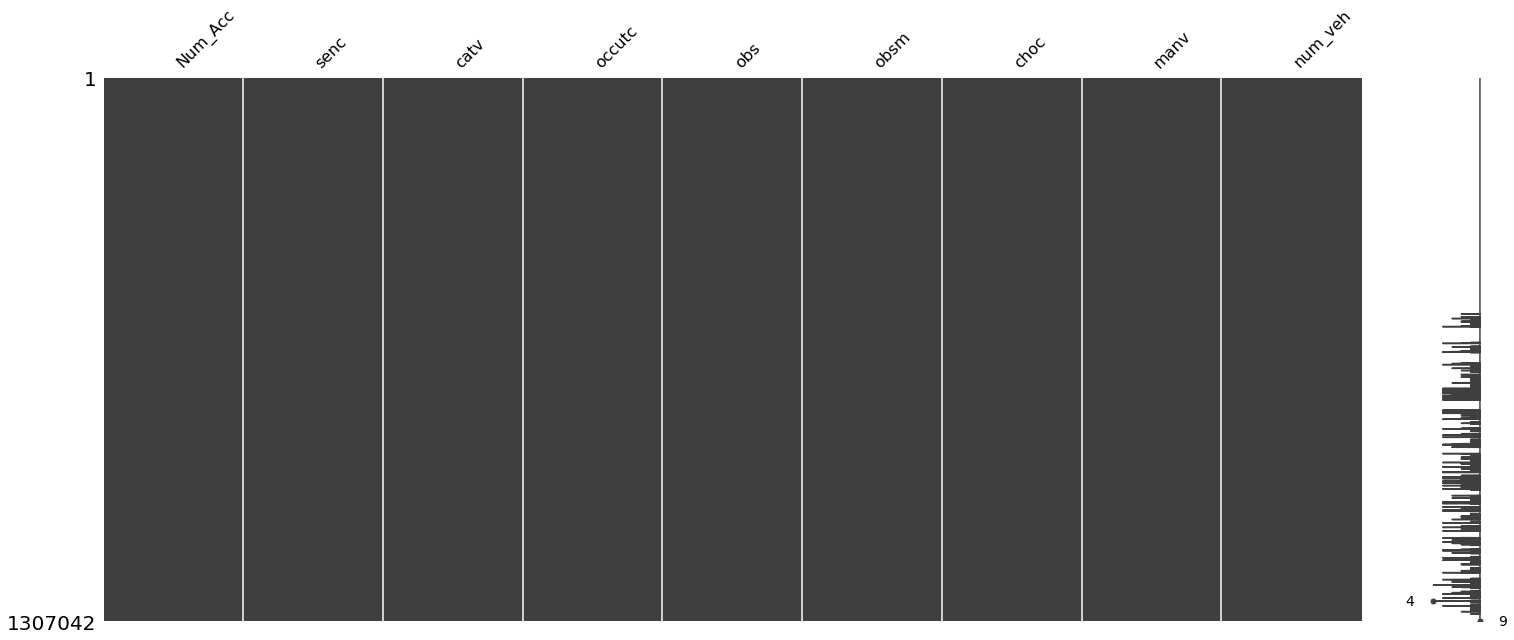

In [128]:
import missingno as msno
msno.matrix(vehicules)

###### Sens de circulation

In [129]:
vehicules.senc.unique()

array([  0.,   1.,   2.,  nan])

In [130]:
print("taille 0 :" , vehicules[vehicules.senc==0].shape)
print("taille nan :" , vehicules.senc.isnull().sum())

taille 0 : (1199403, 9)
taille nan : 72


In [131]:
vehicules.loc[:,['senc']]=vehicules.loc[:,['senc']].replace(0,np.nan)

###### Catégorie du véhicule :

In [132]:
print(len(vehicules.catv.unique()))
vehicules.catv.unique()
#Ok

33


array([ 7,  2,  9,  5, 18, 17,  1, 10,  4, 15, 19, 14, 13, 12, 21, 20, 99,
        3, 16,  8,  6, 11, 38, 32, 37, 30, 36, 31, 33, 39, 34, 35, 40], dtype=int64)

###### Obstacle mobile heurté :

In [133]:
vehicules.obsm.unique()

array([  2.,   0.,   1.,   9.,   4.,   5.,   6.,  nan])

In [134]:

vehicules.loc[:,['obsm']]=vehicules.loc[:,['obsm']].replace(0,np.nan)

###### Point de choc initial :

In [135]:
vehicules.choc.unique()

array([  1.,   8.,   7.,   0.,   3.,   2.,   6.,   4.,   5.,   9.,  nan])

In [136]:
vehicules.loc[:,['choc']]=vehicules.loc[:,['choc']].replace(0,np.nan)

###### Nombre d’occupants dans le transport en commun

In [137]:
vehicules.occutc.unique()
# 0 pour dire que ce n'est pas transport commun.

array([  0,   1,   2,  26,  23,  36,  31,   6,  51,  27,  52,  25,  10,
         8,  14,  20,  11,  40,  33,  12,   3,  13,  45,  39,   5,  15,
        32, 100,  30,  29,  35,  41,   4,  21,  16,  18,  37,  60,  62,
        46,  50,  28,  44,   7,  57,  42,   9,  17,  58,  24,  43,  48,
        22, 470,  69,  61, 150,  47, 120,  66,  49,  38,  54,  59, 200,
        34,  53,  55,  96,  65, 210,  63,  93,  80,  85, 213,  64, 193,
       111,  70, 700, 300,  73,  74,  19,  72, 110,  97,  56,  75, 220,
        81,  95,  84,  83,  67,  76,  89,  90, 480, 140,  99, 240,  71,
       132, 125, 153, 184, 170, 130, 490, 250], dtype=int64)

###### manv

In [138]:
# manv de type int
vehicules.manv.isnull().sum()

227

save to csv file 

In [139]:
vehicules.to_csv('data-without-imputing-all-years/vehicules_2005-2016.csv', index=False)

---
Fin nettoyage 
---

Dans le but d'une bonne gestion de mémoire on va éliminer toutes les variables, puis on récupére nos tables déjà nettoyées.

# La jointure des tables :

In [192]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 1. Jointure sur toute la période( 2005-2016) :

In [289]:
import pandas as pd
import datetime as dt # to create a feature for dayOfWeek
#load caracteristiques :
caracteristiques=pd.read_csv('dataset-without-imputing-2005-2016/caracteristiques_2005-2016.csv', encoding='latin-1')

#load lieux :
lieux=pd.read_csv('dataset-without-imputing-2005-2016/lieux_2005-2016.csv',encoding='latin-1')

# load vehicules : 
vehicules=pd.read_csv('dataset-without-imputing-2005-2016/vehicules_2005-2016.csv',encoding='latin-1')

# load usagers :
usagers=pd.read_csv('dataset-without-imputing-2005-2016/usager_2005-2016.csv',encoding='latin-1')

# on merge caracteristiques et lieux puis on merge avec vehicules : 
carac_lieux_veh_merged=pd.merge(pd.merge(caracteristiques,lieux,on='Num_Acc'), vehicules,on='Num_Acc' )
#on merge finalement avec usagers :
data_merged=pd.merge(carac_lieux_veh_merged,usagers,on=['Num_Acc','num_veh'])

# feature engineering :
##age : 
data_merged.loc[:,['an']]=data_merged.loc[:,['an']]+2000
data_merged['age']=pd.Series(data_merged.an.values - data_merged.an_nais.values)

## day of week 
data_merged.loc[:,'an']=data_merged.loc[:,'an']
# change type to object for easy handling : 
col_object=['an','mois','jour'] 
for c in col_object:
    data_merged[c]=data_merged[c].astype(str)
# join the three feature to obtain the date   
data_merged['date'] = data_merged[['an','mois','jour']].apply(lambda x: '-'.join(x), axis=1) 
#convert to date format
data_merged['date']=pd.to_datetime(data_merged['date'])
#day_of_week : day correseponding to each date
data_merged['day_of_week']=data_merged['date'].dt.weekday_name
# encode days into integers
data_merged['day_of_week_encoded']=data_merged.day_of_week.astype("category").cat.codes

## nuit ou non ? 
# variable nuit : cette variable sera 1 si l'accident a eu lieu pendant la nuit( entre 18h et 6h) et 0 sinon
data_merged['nuit']=pd.to_datetime(data_merged.hrmn, format='%H:%M').dt.hour
data_merged.loc[ ((data_merged['nuit'] >= 0) & (data_merged['nuit'] <= 6))|((data_merged['nuit'] >= 18) & (data_merged['nuit'] <= 23)),'nuit']=1  #1 for night
data_merged.loc[ (data_merged['nuit'] >=7) & (data_merged['nuit'] <= 17),'nuit']=0  #0 for day
    
## les heures de pointes :
data_merged['heure_pointe']=pd.to_datetime(data_merged.hrmn, format='%H:%M').dt.hour

data_merged.loc[ ((data_merged['heure_pointe'] >13) & (data_merged['heure_pointe'] <= 15))|
         ((data_merged['heure_pointe'] == 10))|
         ((data_merged['heure_pointe'] >19) & (data_merged['heure_pointe'] <= 23))|
         ((data_merged['heure_pointe'] >=0) & (data_merged['heure_pointe'] <= 6)),'heure_pointe']=0    # pas heure de pointe


data_merged.loc[ ((data_merged['heure_pointe'] >= 7) & (data_merged['heure_pointe'] <= 9))|
         ((data_merged['heure_pointe'] >= 11) & (data_merged['heure_pointe'] <= 13))|
         ((data_merged['heure_pointe'] >= 11) & (data_merged['heure_pointe'] <= 13))|
         ((data_merged['heure_pointe'] >=16) & (data_merged['heure_pointe'] <= 19)),'heure_pointe']=1    # heure de pointe


# save data : 
data_merged.to_csv('data-without-imputing-all-years/data_merged-2005-2016.csv',index=False)


C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Jointure année par année

In [194]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [295]:
#required libraries :
import pandas as pd
#load datasets :
caracteristiques=pd.read_csv('dataset-without-imputing-2005-2016/caracteristiques_2005-2016.csv',encoding='latin-1')
vehicules=pd.read_csv('dataset-without-imputing-2005-2016/vehicules_2005-2016.csv',encoding='latin-1')
lieux=pd.read_csv('dataset-without-imputing-2005-2016/lieux_2005-2016.csv',encoding='latin-1')
usagers=pd.read_csv('dataset-without-imputing-2005-2016/usager_2005-2016.csv',encoding='latin-1')

# create dataframes per year :

dfs=[] # a list that will contain data for each year
col_years=[2005,2006,2007,2008,2010,2011,2012,2013,2014,2015,2016]
for year in col_years :
    cara=caracteristiques.loc[caracteristiques['Num_Acc']//100000000==year] # cara is a dataframe for year='year'
    # feature engineering :
    ## day of week :
    cara.loc[:,'an']=cara.loc[:,'an']+2000  # add 2000 to 'an' feature
    # change type to object for easy handling : 
    col_object=['an','mois','jour'] 
    for col in col_object:
        cara[col]=cara[col].astype(str)
    # join the three feature to obtain the date   
    cara['date'] = cara[['an','mois','jour']].apply(lambda x: '-'.join(x), axis=1) 
    #convert to date format
    cara['date']=pd.to_datetime(cara['date'])
    #day_of_week : day correseponding to each date
    cara['day_of_week']=cara['date'].dt.weekday_name
    # encode days into integers
    cara['day_of_week_encoded']=cara.day_of_week.astype("category").cat.codes
    ## nuit ou non ? 
    # variable nuit : cette variable sera 1 si l'accident a eu lieu pendant la nuit( entre 18h et 6h) et 0 sinon
    cara['nuit']=pd.to_datetime(cara.hrmn, format='%H:%M').dt.hour
    cara.loc[ ((cara['nuit'] >= 0) & (cara['nuit'] <= 6))|((cara['nuit'] >= 18) & (cara['nuit'] <= 23)),'nuit']=1  #1 for night
    cara.loc[ (cara['nuit'] >=7) & (cara['nuit'] <= 17),'nuit']=0  #0 for day
    
    ## les heures de pointes :
    cara['heure_pointe']=pd.to_datetime(cara.hrmn, format='%H:%M').dt.hour

    cara.loc[ ((cara['heure_pointe'] >13) & (cara['heure_pointe'] <= 15))|
         ((cara['heure_pointe'] == 10))|
         ((cara['heure_pointe'] >19) & (cara['heure_pointe'] <= 23))|
         ((cara['heure_pointe'] >=0) & (cara['heure_pointe'] <= 6)),'heure_pointe']=0    # pas heure de pointe


    cara.loc[ ((cara['heure_pointe'] >= 7) & (cara['heure_pointe'] <= 9))|
         ((cara['heure_pointe'] >= 11) & (cara['heure_pointe'] <= 13))|
         ((cara['heure_pointe'] >= 11) & (cara['heure_pointe'] <= 13))|
         ((cara['heure_pointe'] >=16) & (cara['heure_pointe'] <= 19)),'heure_pointe']=1    # heure de pointe
    
    veh=vehicules.loc[vehicules['Num_Acc']//100000000==year]
    usa=usagers.loc[usagers['Num_Acc']//100000000==year]
    lie=lieux.loc[lieux['Num_Acc']//100000000==year]
    #merge c and l :
    merge1=pd.merge(cara,lie,on='Num_Acc')
    #merge merge1 and v :
    merge2=pd.merge(merge1,veh,on='Num_Acc')
    # finally we merge with u :
    data=pd.merge(merge2,usa,on=['Num_Acc','num_veh'])
    # add the dataframe data to the list dfs :
    dfs.append(data)
    
# save all dataframes into a csv files :
for index, item in enumerate(dfs, start = 1):
    #data1.csv : dataframe about 2005, data2.csv : dataframe about 2006, ...etc
    item.to_csv('dataset-without-imputing-2005-2016/data_without_imputing'+str(index)+'.csv',index=False)

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

Les données sont prêtes, nous allons maintenant effectuer notre d'algorithme. (voir notebook : classification_gravite.ipynb)